## Importamos todos los paquetes aquí por comodidad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

In [3]:
import os
os.getcwd()
import pandas as pd
import numpy as np
from scipy import stats
from scipy import optimize as opt  # para estimación por máxima verosimilitud
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF

import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate

from statsmodels.nonparametric.kernel_density import KDEMultivariate
import matplotlib.tri as tri

from scipy import interpolate

## Cargamos los datos con los que se trabaja

In [4]:
nom_fi_datos = 'G02B_DATOS_DEM_M4.csv'

In [5]:
df_orig = pd.read_csv(nom_fi_datos)

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
df_orig.FECHA = pd.to_datetime(df_orig.FECHA, format='%d/%m/%Y') 
s=df_orig.loc[:,'FECHA']
df_orig['DATE'] =  s.dt.date
del df_orig['FECHA']

# añadimos el año-semana para luego poder trabajar cómodamente con el dataframe
ywd=s.dt.isocalendar()
yw = 1000*ywd['year'] + ywd['week'] # por ejemplo 2022032 es la semana 32 del año 2022
df_orig['ANNO-SEMANA'] = yw

print('Tamaño de df_orig con los datos cargados:', df_orig.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
print(df_orig)
df = df_orig

Tamaño de df_orig con los datos cargados: (1627, 33)
Dataframe con todos los datos leidos (filas: días, columnas: variables):
          CR00      CR01      CR02      CR03      CR04      CR05      CR06  \
0     0.039126  0.035324  0.032842  0.031533  0.030857  0.030710  0.030730   
1     0.039032  0.035356  0.032867  0.031417  0.030783  0.030597  0.030657   
2     0.039508  0.035976  0.033711  0.032332  0.031694  0.031551  0.031673   
3     0.040454  0.036701  0.034026  0.032566  0.031944  0.031670  0.031479   
4     0.042847  0.039526  0.036950  0.035158  0.034001  0.033421  0.032762   
...        ...       ...       ...       ...       ...       ...       ...   
1622  0.037500  0.034070  0.031581  0.030255  0.029750  0.030143  0.032196   
1623  0.038127  0.034337  0.031761  0.030471  0.029983  0.030307  0.032492   
1624  0.038088  0.034451  0.031834  0.030294  0.029645  0.029982  0.032268   
1625  0.037944  0.034254  0.031777  0.030190  0.029627  0.029865  0.032261   
1626  0.039021  

### 1. Visión general de las series

In [6]:
# auxiliares útiles para la representación
fechas = df_orig.DATE.tolist()

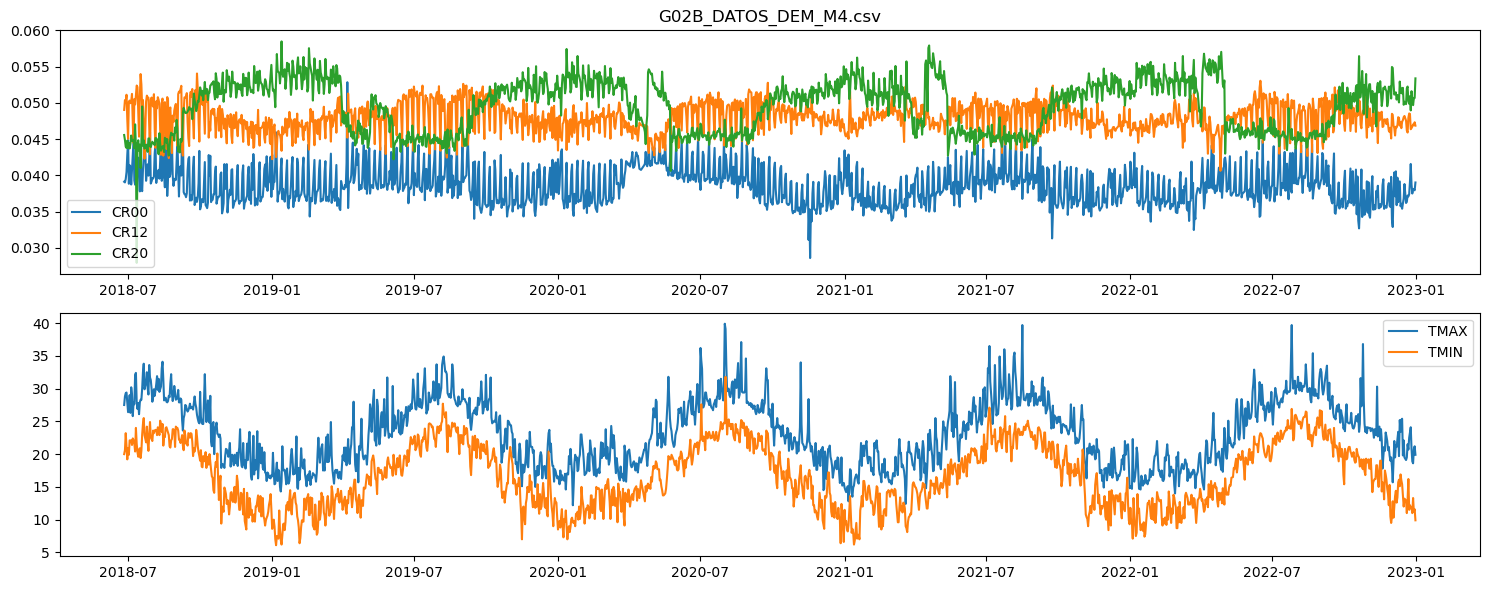

In [7]:
fig = plt.figure(1, figsize=(15,6)) # permite indicar el nº de la figura y las dimensiones (ancho y alto)
ax1 = plt.subplot(2,1,1)
plt.plot(fechas, df_orig.CR00, label='CR00')
plt.plot(fechas, df_orig.CR12, label='CR12')
plt.plot(fechas, df_orig.CR20, label='CR20')
plt.title(nom_fi_datos)
plt.legend()

plt.subplot(2,1,2,sharex= ax1)
plt.plot(fechas, df_orig.TMAX, label='TMAX')
plt.plot(fechas, df_orig.TMIN, label='TMIN')
plt.tight_layout()
plt.legend()

plt.show()

fig.savefig('figura1.pdf')

PARTE 2

Contraste KS

In [8]:
lista_coef = [df.CR00, df.CR01, df.CR02, df.CR03, df.CR04, df.CR05, df.CR06, df.CR07, df.CR08, df.CR09, df.CR10, df.CR11, df.CR12, df.CR13, df.CR14, df.CR15, df.CR16, df.CR17, df.CR18, df.CR19, df.CR20, df.CR21, df.CR22, df.CR23]
print(lista_coef[0])

0       0.039126
1       0.039032
2       0.039508
3       0.040454
4       0.042847
          ...   
1622    0.037500
1623    0.038127
1624    0.038088
1625    0.037944
1626    0.039021
Name: CR00, Length: 1627, dtype: float64


Hacemos el contraste KS con cada uno de los coeficientes

In [9]:
# nivel de significación
alfa = 0.05
lista_pvalores = []
for i in range(24):
    # realiza el test
    ks = sm.stats.diagnostic.kstest_normal(lista_coef[i], dist='norm', pvalmethod='table')
    max_d   = ks[0]
    p_valor = ks[1]
    lista_pvalores.append(p_valor)

print(lista_pvalores)

[0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.07117064620775874, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.08540052743176219, 0.0009999999999998899, 0.0009999999999998899, 0.010616347495354731, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899, 0.0009999999999998899]


In [10]:
for i in range(24):
    if lista_pvalores[i] > alfa:
        print(f" El coeficiente {i} sigue una distribición normal p_valor = {lista_pvalores[i]}")
        

 El coeficiente 6 sigue una distribición normal p_valor = 0.07117064620775874
 El coeficiente 12 sigue una distribición normal p_valor = 0.08540052743176219


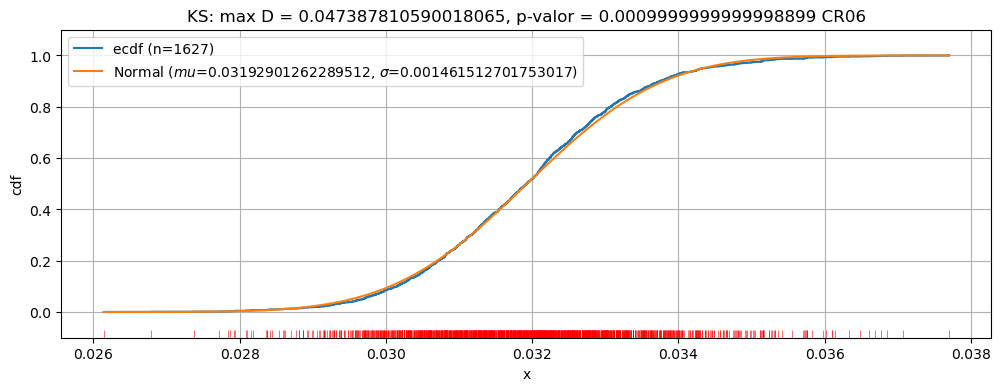

In [11]:
# Representación visual del contraste
x = df.CR06
n = len(df.CR06)
# estima coefs de la normal
va_teo = stats.norm(np.mean(x), np.std(x))

# calcula acumulada empírica
ecdf = sm.distributions.empirical_distribution.ECDF(x)

# crea gráfica
xs = np.linspace(min(va_teo.ppf(0.01), min(x)), max(va_teo.ppf(1-0.01), max(x)), 1000)

fig = plt.figure(1, figsize=(12, 4))
plt.step(ecdf.x, ecdf.y, label=f'ecdf (n={n})', where='post')
plt.plot(xs, va_teo.cdf(xs), label=f'Normal ($mu$={np.mean(x)}, $\sigma$={np.std(x)})')
sns.rugplot(x, height = 0.025, lw = 0.4, color = 'red')
plt.title(f'KS: max D = {max_d}, p-valor = {p_valor} CR06')
plt.grid()
plt.xlabel('x');plt.ylabel('cdf');plt.legend()
plt.show()

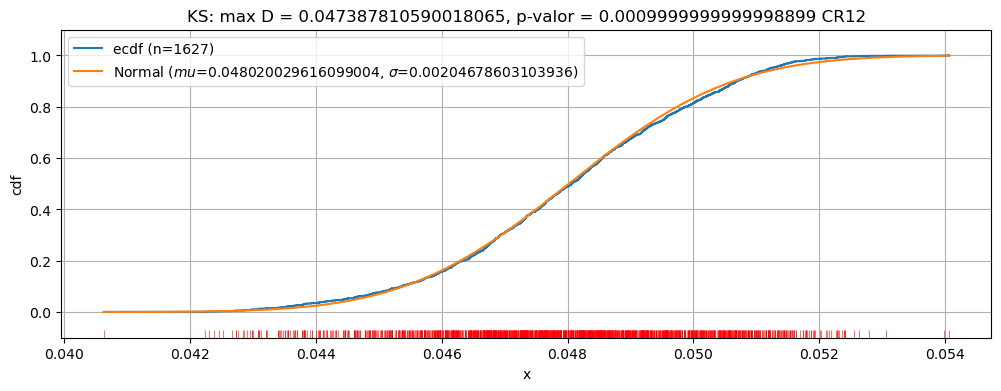

In [12]:
# Representación visual del contraste
x = df.CR12
n = len(df.CR12)
# estima coefs de la normal
va_teo = stats.norm(np.mean(x), np.std(x))

# calcula acumulada empírica
ecdf = sm.distributions.empirical_distribution.ECDF(x)

# crea gráfica
xs = np.linspace(min(va_teo.ppf(0.01), min(x)), max(va_teo.ppf(1-0.01), max(x)), 1000)

fig = plt.figure(1, figsize=(12, 4))
plt.step(ecdf.x, ecdf.y, label=f'ecdf (n={n})', where='post')
plt.plot(xs, va_teo.cdf(xs), label=f'Normal ($mu$={np.mean(x)}, $\sigma$={np.std(x)})')
sns.rugplot(x, height = 0.025, lw = 0.4, color = 'red')
plt.title(f'KS: max D = {max_d}, p-valor = {p_valor} CR12')
plt.grid()
plt.xlabel('x');plt.ylabel('cdf');plt.legend()
plt.show()

Conclusiones contraste KS: 
El CR06 sigue una distribución normal
El CR12 sigue una distrubuión normal

Parámetros de las distribuciones normales CR06 y CR12

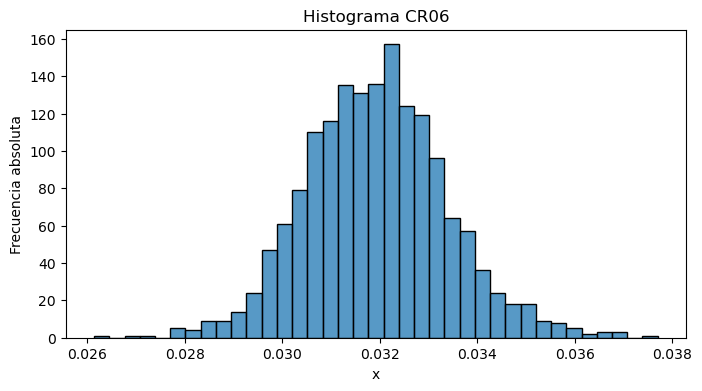

In [13]:
nbins = 'auto' # número de intervalos, ajustar para buena visualización

fig = plt.figure(1, figsize=(8, 4)) # permite indicar el nº de la figura y las dimensiones (ancho y alto)
sns.histplot(data=df.CR06, bins=nbins)
# sns.rugplot(x, color='r')                            # opcional
plt.title(f'Histograma CR06')
plt.xlabel('x')
plt.ylabel('Frecuencia absoluta')
plt.show()

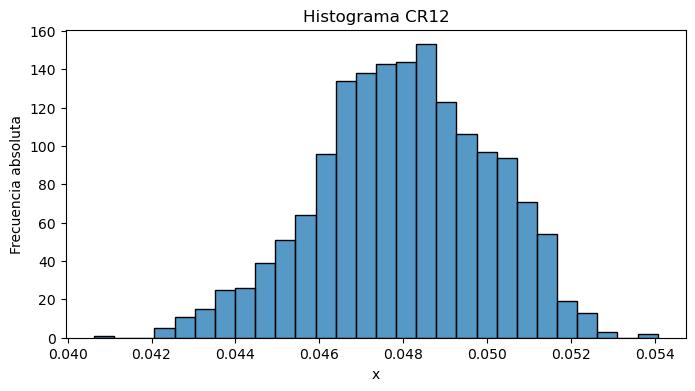

In [14]:
nbins = 'auto' # número de intervalos, ajustar para buena visualización
fig = plt.figure(1, figsize=(8, 4)) # permite indicar el nº de la figura y las dimensiones (ancho y alto)
sns.histplot(data=df.CR12, bins=nbins)
# sns.rugplot(x, color='r')                            # opcional
plt.title(f'Histograma CR12')
plt.xlabel('x')
plt.ylabel('Frecuencia absoluta')
plt.show()

Ajustamos la distrubución normal a los datos CR06 y CR12

In [15]:
print(f"Media CR06: {np.mean(df.CR06)}")
print(f"Desviacíon típica CR06: {np.std(df.CR12)}")
print(f"Media CR12: {np.mean(df.CR06)}")
print(f"Desviacíon típica CR12: {np.std(df.CR12)}")

mu = np.mean(df.CR06)
sigma = np.std(df.CR06)
VA_CR06 = stats.norm(loc = mu, scale = sigma)

mu = np.mean(df.CR12)
sigma = np.std(df.CR12)
VA_CR12 = stats.norm(loc = mu, scale = sigma)


Media CR06: 0.03192901262289512
Desviacíon típica CR06: 0.00204678603103936
Media CR12: 0.03192901262289512
Desviacíon típica CR12: 0.00204678603103936


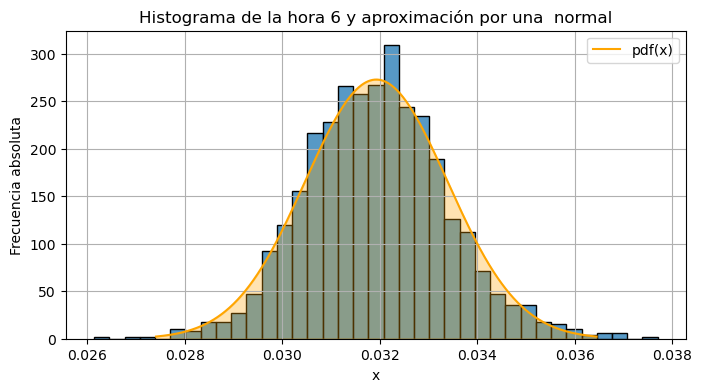

In [18]:
nbins = 'auto' # número de intervalos, ajustar para buena visualización
xs = np.linspace(VA_CR06.ppf(0.001), VA_CR06.ppf(0.999), 1000)
fig = plt.figure(1, figsize=(8, 4)) # permite indicar el nº de la figura y las dimensiones (ancho y alto)
sns.histplot(data=df.CR06, bins=nbins,stat='density')
plt.plot( xs, VA_CR06.pdf(xs), color="orange", label = 'pdf(x)')
plt.fill_between( xs, VA_CR06.pdf(xs), color="orange", alpha=0.3)
# sns.rugplot(x, color='r')                            # opcional
plt.title(f'Histograma de la hora 6 y aproximación por una  normal')
plt.xlabel('x')
plt.ylabel('Frecuencia absoluta')
plt.legend()
plt.grid()
plt.show()

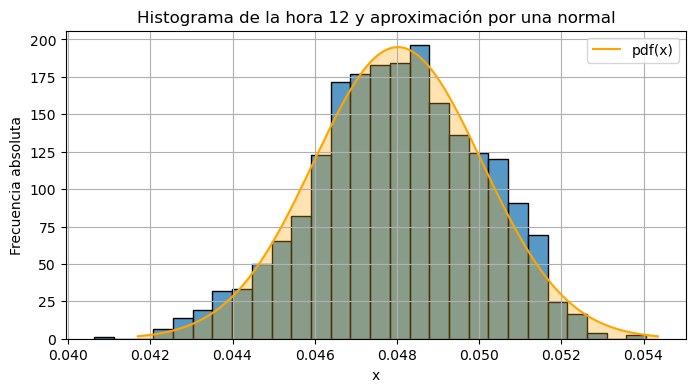

In [20]:
nbins = 'auto' # número de intervalos, ajustar para buena visualización
xs = np.linspace(VA_CR12.ppf(0.001), VA_CR12.ppf(0.999), 1000)
fig = plt.figure(1, figsize=(8, 4)) # permite indicar el nº de la figura y las dimensiones (ancho y alto)
sns.histplot(data=df.CR12, bins=nbins,stat='density')
plt.plot( xs, VA_CR12.pdf(xs), color="orange", label = 'pdf(x)')
plt.fill_between( xs, VA_CR12.pdf(xs), color="orange", alpha=0.3)
# sns.rugplot(x, color='r')                            # opcional
plt.title(f'Histograma de la hora 12 y aproximación por una normal')
plt.xlabel('x')
plt.ylabel('Frecuencia absoluta')
plt.legend()
plt.grid()
plt.show()

QQ-plot CR06 y CR12

In [ ]:
# nombre de la distribución teórica que se contrasta (norm, uniform, triang, expon, ...)
distribucion_teo = stats.norm

# genera qqplot de la variable x
sm.qqplot(df.CR06, line='45', fit=True, dist=distribucion_teo)
plt.title('QQ-plot CR06')
plt.grid(); plt.show()

In [ ]:
# nombre de la distribución teórica que se contrasta (norm, uniform, triang, expon, ...)
distribucion_teo = stats.norm

# genera qqplot de la variable x
sm.qqplot(df.CR12, line='45', fit=True, dist=distribucion_teo)
plt.title('QQ-plot CR12')
plt.grid(); plt.show()

PARTE 4

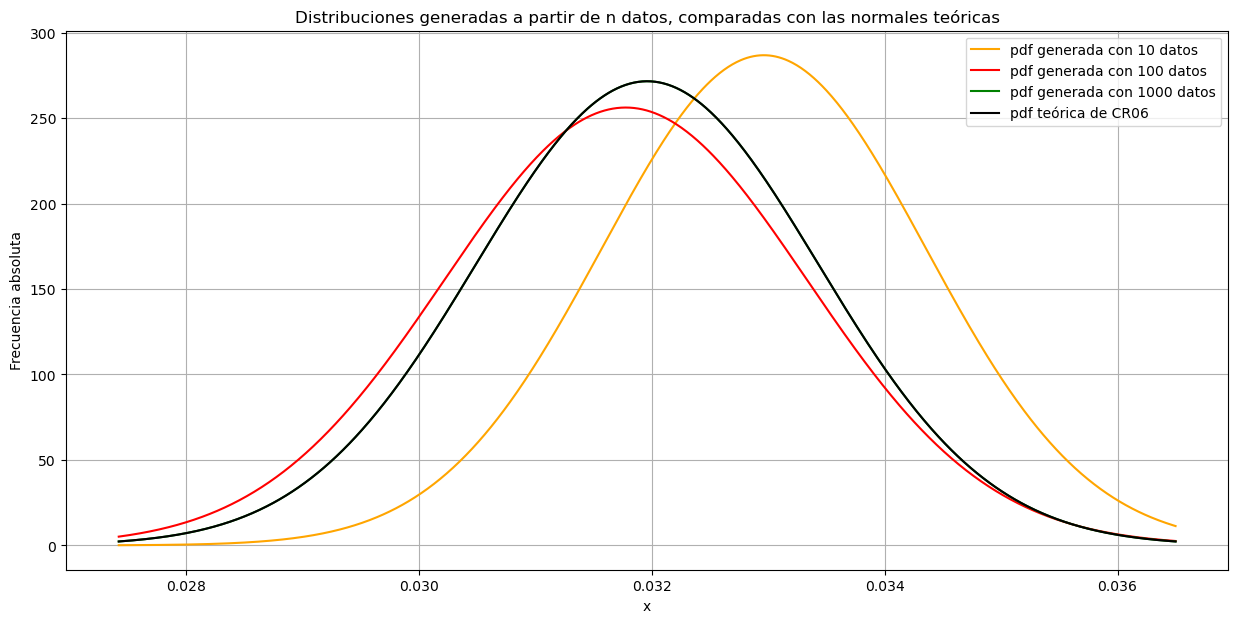

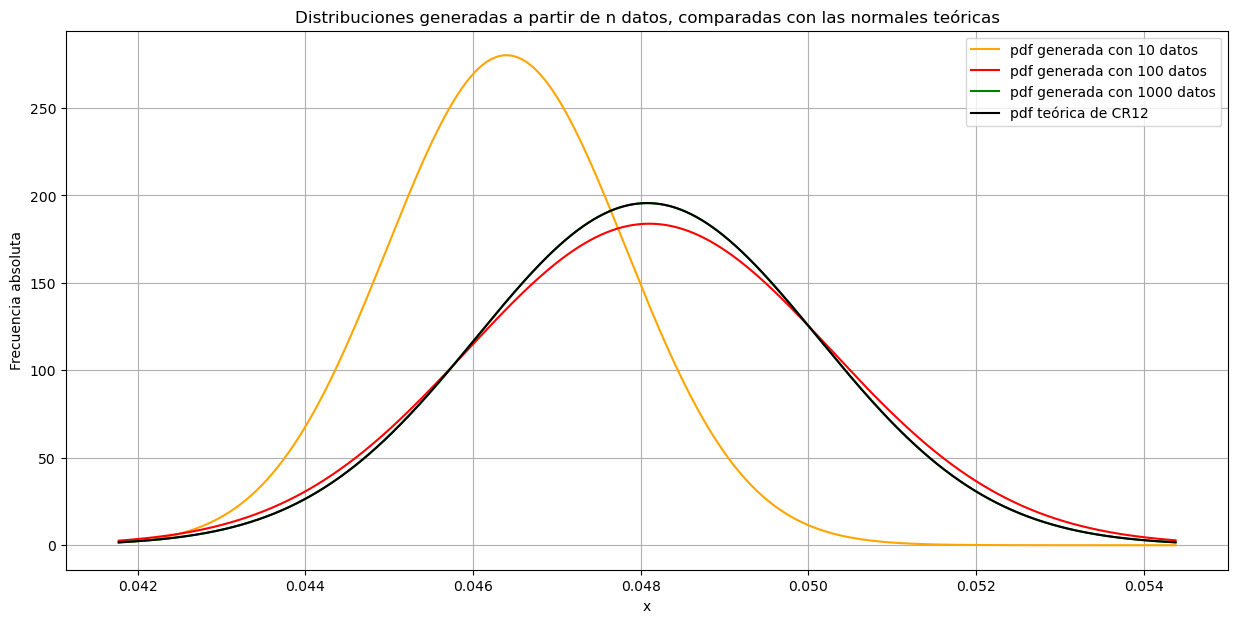

In [63]:
muestras_1000 = []
lista_normales = [df.CR06, df.CR12]
lista_numeros = [10,100,1000]
colores = ["orange","red","green"]
for distribucion in lista_normales:
    datos_generados = []
    for numeros in lista_numeros:
        mu = np.mean(distribucion)
        sigma = np.std(distribucion)
        VA = stats.norm(loc = mu, scale = sigma)
        # genera n números aleatorios segun VA
        n = numeros
        x = VA.rvs(size = n)
        datos_generados.append(x)
        if n == 1000:
            muestras_1000.append(x)
    lista_distribuciones_aleatorias = []
    for datos in datos_generados:
        mu = np.mean(datos)
        sigma = np.std(datos)
        VA = stats.norm(loc = mu, scale = sigma)
        lista_distribuciones_aleatorias.append(VA)
    xs = np.linspace(lista_distribuciones_aleatorias[2].ppf(0.001), lista_distribuciones_aleatorias[2].ppf(0.999), 1000)
    fig = plt.figure(1, figsize=(15, 7)) 
    i = 0
    for distribucion_aleatoria in lista_distribuciones_aleatorias:
        plt.plot( xs, distribucion_aleatoria.pdf(xs), color=colores[i], label = f'pdf generada con {lista_numeros[i]} datos')
        i += 1
    VA_teorica = stats.norm(loc = np.mean(distribucion), scale = np.std(distribucion))
    plt.plot( xs, VA.pdf(xs), color="black", label = f'pdf teórica de {distribucion.name}')
    plt.title(f'Distribuciones generadas a partir de n datos, comparadas con las normales teóricas')
    plt.xlabel('x')
    plt.ylabel('Frecuencia absoluta')
    plt.legend()
    plt.grid()
    plt.show()

        
    

In [ ]:
lista_coef = [df.CR00, df.CR01, df.CR02, df.CR03, df.CR04, df.CR05, df.CR06, df.CR07, df.CR08, df.CR09, df.CR10, df.CR11, df.CR12, df.CR13, df.CR14, df.CR15, df.CR16, df.CR17, df.CR18, df.CR19, df.CR20, df.CR21, df.CR22, df.CR23]

1000
